In [1]:
train_dir = 'training_set'
validation_dir = 'testing_dataset'

# Import the required modules and load the training and validation set

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,shuffle=True,batch_size=32,image_size=(256, 256))
val_dataset = image_dataset_from_directory(validation_dir,shuffle=True,batch_size=32,image_size=(256,256))

Found 621 files belonging to 3 classes.
Found 135 files belonging to 3 classes.


# Data Preprocessing

Data Augmentation

In [3]:
data_augmentation = keras.Sequential([
 keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
 keras.layers.experimental.preprocessing.RandomRotation(0.1),
 ]
 )

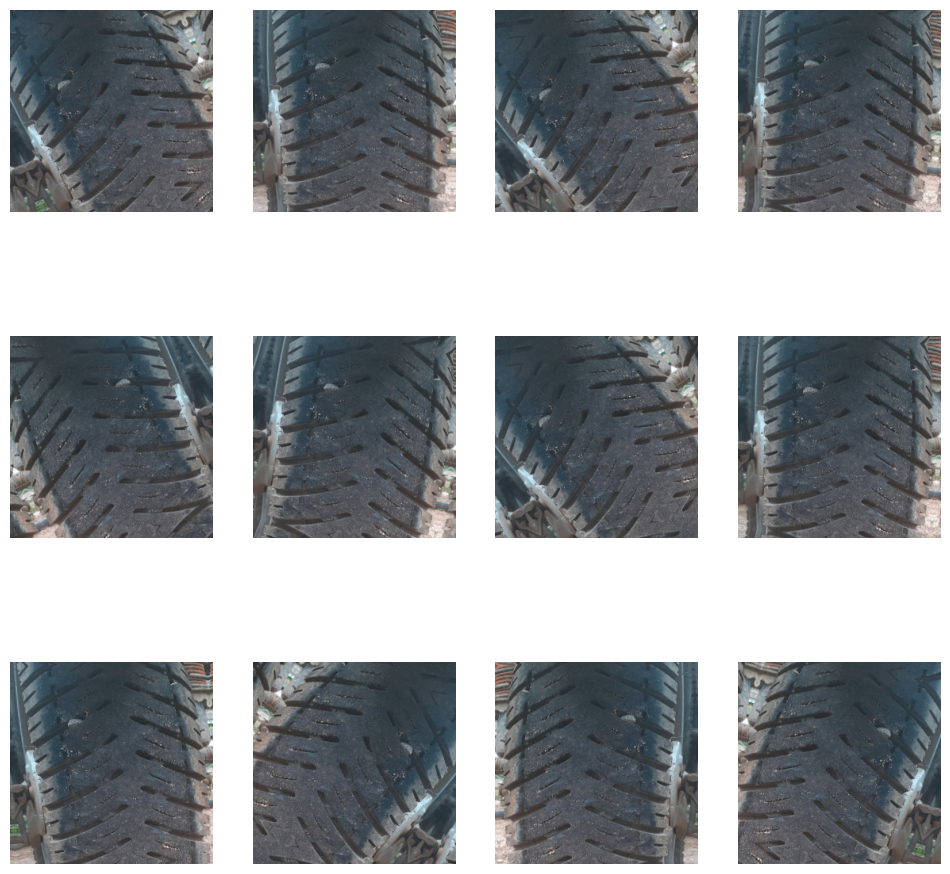

In [4]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
  plt.figure(figsize=(12, 12))
  first_image = images[0]
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = data_augmentation(
    tf.expand_dims(first_image, 0)
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

# Create the base model from the Xceptional model

In [5]:
base_model = keras.applications.Xception(
 weights='imagenet',
 input_shape=(256, 256, 3),
 include_top=False)

In [6]:
base_model.trainable = False

# Create the Final Dense layer

In [7]:
inputs = keras.Input(shape=(256, 256, 3))

In [8]:
x = data_augmentation(inputs)

In [9]:
x = tf.keras.applications.xception.preprocess_input(x)

In [10]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [11]:
print("Number of layers in the base model:", len(base_model.layers))

Number of layers in the base model: 132


# Train the model

In [12]:
model.compile(optimizer='adam',
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())
history=model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
20/20 [==============================] - 45s 2s/step - loss: 0.2097 - binary_accuracy: 0.3510 - val_loss: 0.4131 - val_binary_accuracy: 0.5630
Epoch 2/20
20/20 [==============================] - 36s 2s/step - loss: -0.0225 - binary_accuracy: 0.3559 - val_loss: 0.4645 - val_binary_accuracy: 0.5630
Epoch 3/20
20/20 [==============================] - 31s 2s/step - loss: -0.1317 - binary_accuracy: 0.3559 - val_loss: 0.4950 - val_binary_accuracy: 0.5630
Epoch 4/20
20/20 [==============================] - 31s 2s/step - loss: -0.3226 - binary_accuracy: 0.3559 - val_loss: 0.5313 - val_binary_accuracy: 0.5630
Epoch 5/20
20/20 [==============================] - 31s 2s/step - loss: -0.4053 - binary_accuracy: 0.3559 - val_loss: 0.5819 - val_binary_accuracy: 0.5630
Epoch 6/20
20/20 [==============================] - 31s 2s/step - loss: -0.5153 - binary_accuracy: 0.3575 - val_loss: 0.6758 - val_binary_accuracy: 0.5630
Epoch 7/20
20/20 [==============================] - 31s 2s/step - loss:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
predictions = model.predict(val_dataset)
# Assuming your model outputs logits, you can convert them to class labels
predicted_labels = np.round(tf.sigmoid(predictions))


5/5 [==============================] - 7s 987ms/step


In [15]:
true_labels = []
for _, label in val_dataset:
    true_labels.extend(label.numpy())
true_labels = np.array(true_labels)

In [18]:
true_labels

array([2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1,
       1, 1, 2, 2, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1,
       0, 1, 1])

In [19]:
cm = confusion_matrix(true_labels, predicted_labels)

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good","Moderate"])

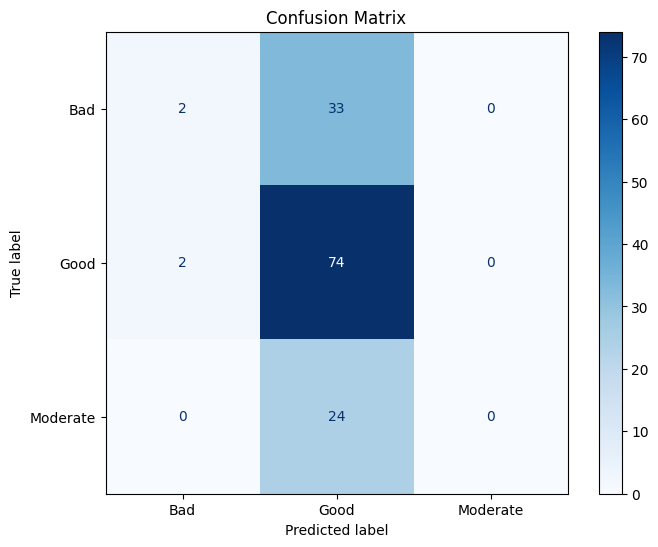

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


Check accuracy

Training Accuracy: 0.3800322115421295
Validation Accuracy: 0.5407407283782959


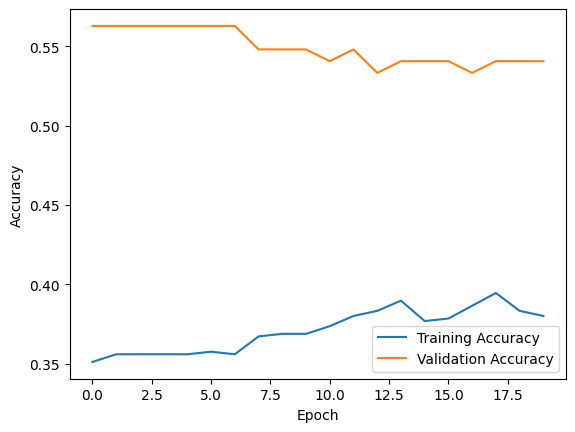

In [22]:
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Fine tuning

In [23]:
base_model.trainable = True

fine_tune_from = 70

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

history_fine_tune = model.fit(training_set, epochs=10, validation_data=val_dataset)



Epoch 1/10
20/20 [==============================] - 78s 4s/step - loss: -18.9848 - binary_accuracy: 0.4155 - val_loss: 45.9561 - val_binary_accuracy: 0.5630
Epoch 2/10
20/20 [==============================] - 72s 4s/step - loss: -479.4067 - binary_accuracy: 0.4090 - val_loss: 1419.1980 - val_binary_accuracy: 0.5630
Epoch 3/10
20/20 [==============================] - 71s 3s/step - loss: -41287.1367 - binary_accuracy: 0.3897 - val_loss: 144647.3125 - val_binary_accuracy: 0.5630
Epoch 4/10
20/20 [==============================] - 65s 3s/step - loss: -13035695.0000 - binary_accuracy: 0.3849 - val_loss: 50101648.0000 - val_binary_accuracy: 0.5630
Epoch 5/10
20/20 [==============================] - 65s 3s/step - loss: -4290920192.0000 - binary_accuracy: 0.4010 - val_loss: 14423236608.0000 - val_binary_accuracy: 0.5630
Epoch 6/10
20/20 [==============================] - 73s 4s/step - loss: -543949651968.0000 - binary_accuracy: 0.4058 - val_loss: 1345032945664.0000 - val_binary_accuracy: 0.563

Fine-Tuning Training Accuracy: 0.9954057931900024
Fine-Tuning Validation Accuracy: 0.9921568632125854


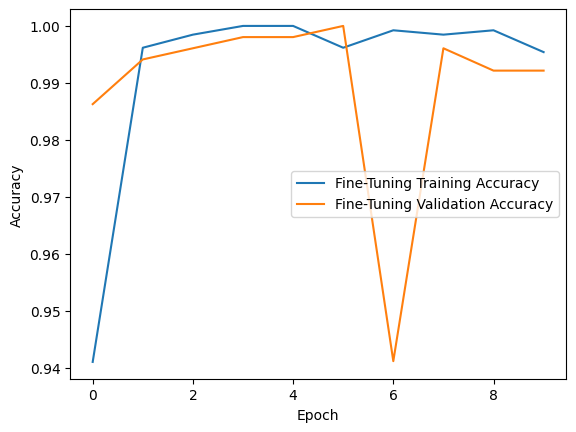

In [21]:

fine_tune_train_accuracy = history_fine_tune.history['binary_accuracy']
fine_tune_val_accuracy = history_fine_tune.history['val_binary_accuracy']

print("Fine-Tuning Training Accuracy:", fine_tune_train_accuracy[-1])
print("Fine-Tuning Validation Accuracy:", fine_tune_val_accuracy[-1])

plt.plot(fine_tune_train_accuracy, label='Fine-Tuning Training Accuracy')
plt.plot(fine_tune_val_accuracy, label='Fine-Tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()